# Neural Networks for Data Science Applications
## Mid-term Homework: Implementing a custom activation function

**Name**: *Sabriye Ela Esme*

**Matricola**: *1912580*

Send the completed notebook before 26/11/2020 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_1_\<id\>".

In [1]:
import tensorflow as tf

### Introduction

The **exponential linear unit** (ELU) is an activation function defined as [1]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\left(x\right)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where $\alpha$ is a hyper-parameter. The function is implemented in `tf.keras.layers.ELU` (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU)).

The **parametric ELU** (PELU) extends the ELU activation function as [2]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
\frac{\alpha}{\beta}x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where the major difference is that $\alpha,\beta > 0$ are *trainable* parameters, i.e., a pair of $(\alpha, \beta)$ values is trained for each unit in the network.

### Exercise 1: implement the PELU

In TensorFlow, it is possible to implement new layers by subclassing `tf.keras.layers.Layer`:

+ [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)
+ [Custom layers](https://www.tensorflow.org/tutorials/customization/custom_layers)
+ [tf.keras.layers.Layer (documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

**Exercise 1**: *After carefully reading the guides*, complete the following implementation of the PELU activation function.

In [2]:
#From the constraints(callable) page you provided us as a hint, I found out the codes for the different constraints and I realized there are some options
#but there is no option for 'positive', So I took the NonNeg class, and I just changed the greater_equal function to greater and now I have my positive constraint

class PELU(tf.keras.layers.Layer):

    def __init__(self, units=32):
        super(PELU, self).__init__()
        self.units = units

    #BUILDED NON NEGATIVE TRAINABLE CONSTRAINTS
    def build(self, input_shape):
        # TODO: write the code here
        self.alpha = self.add_weight(shape=(self.units,),initializer="ones",trainable=True, constraint="non_neg")
        self.beta = self.add_weight(shape=(self.units,), initializer="ones", trainable=True, constraint="non_neg")

    #USED +1e-6 AS SUGGESTED TO AVOID THE NaNS DURING TRAINING
    def call(self, inputs):
        newinp=tf.where(inputs>=0, (self.alpha/self.beta+1e-6)*inputs, self.alpha*(tf.exp(inputs/self.beta+1e-6)-1))
        return newinp

    def get_config(self):
        config = super(PELU, self).get_config()
        config.update({"units": self.units})
        return config

    

    



**Hints for a correct implementation**:

1. The layer (probably) requires two sets of trainable variables, whose shape depends on the number of units.
2. From the definition of the PELU, $\alpha, \beta$ are required to be positive in order to ensure differentiability. The simplest way to handle this is to use a [constraint callable](https://www.tensorflow.org/api_docs/python/tf/keras/constraints) when creating the weight (see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) for `add_weight`).

### Exercise 2: some preliminary tests

To evaluate your implementation, let us start by creating a single PELU function:

In [3]:
pelu = PELU(units=1)

**Exercise 2.1**: plot the function using the skeleton code below.

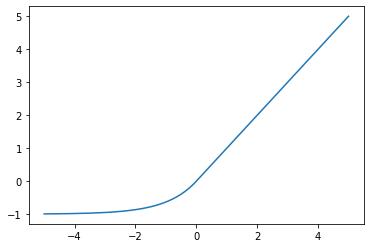

In [4]:
import matplotlib.pyplot as plt
import numpy as np
x_range = tf.dtypes.cast(tf.linspace(-5, 5, 200), tf.float32) # An equispaced grid of 200 points in [-5, +5]
y_range = tf.dtypes.cast(pelu(x_range), tf.float32)           #THE OUTPUTS OF PELU

plt.plot(np.asarray(x_range), np.asarray(y_range))

The derivative of a PELU function with respect to the $\alpha$ parameter is given by [2]:

$$
\frac{d\phi(x)}{d\alpha} =
\Biggl\{ 
\begin{align} 
\frac{x}{\beta} & \;\; \text{ if } x \ge 0 \\
 \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

**Exercise 2.2**: using a `tf.GradientTape` object, compute the derivative above using automatic differentiation, and check its correctness up to a certain numerical precision.

**Hints for a correct implementation**:

1. `tf.GradientTape` allows to compute the derivative *at a single point x*. If you prefer to avoid a loop over all possible points, consider using the `jacobian` function to obtain them in a single pass ([Advanced Automatic Differentiation](https://www.tensorflow.org/guide/advanced_autodiff)).
2. Given two tensors x and y, a simple way to compute elementwise similarity up to a certain precision (e.g., $10^{-4}$), is given by `tf.reduce_all(tf.abs(x - y) < 1e-4)`.

**Exercise 2.3 (optional)**: try the same for the $\beta$ parameter (you can check the analytical formula for the gradient in the original paper [2]). **Careful**: the equation in the original paper has a missing $h$ (thanks to Davide Aureli and Federico Siciliano for spotting this). See [the correct derivation](https://www.wolframalpha.com/input/?i=d%28a*%28exp%28h%2Fb%29-1%29%29%2Fdb) on Wolfram Alpha.

In [5]:
#MANUAL GRADIENT 
#y=pelu(x_range)
y_grad=tf.where(x_range>=0, x_range/(pelu.beta+1e-6), tf.exp(x_range/pelu.beta+1e-6)-1)

In [6]:
#TF GRADIENT 
with tf.GradientTape() as tape:
  yy=pelu(x_range)

dy_dx = tf.reshape(tape.jacobian(yy, pelu.alpha), -1)

In [7]:
tf.reduce_all(tf.abs(y_grad - dy_dx) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [8]:
#FOR BETA
y_grad1=tf.where(x_range>=0, (-1*pelu.alpha*x_range)/(pelu.beta+1e-6)**2, (tf.exp(x_range/pelu.beta+1e-6)*-1*pelu.alpha*x_range)/(pelu.beta+1e-6)**2)

In [9]:
with tf.GradientTape() as tape:
  yy=pelu(x_range)

dy_dx1 = tf.reshape(tape.jacobian(yy, pelu.beta), -1)

In [10]:
tf.reduce_all(tf.abs(y_grad1 - dy_dx1) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### Exercise 3: PELU in practice

Consider a simple model built with the PELU activation function, as below.

In [11]:
#ADDED A FLATTEN LAYER 
model = tf.keras.Sequential(layers=[tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
      tf.keras.layers.Dense(50),
      PELU(50),
      tf.keras.layers.Dense(10, activation='softmax')
])

**Exercise 3**: load any classification dataset, and train the model above (using either a custom training loop or `model.fit(...)`). Additionally, compare with a standard ReLU activation.

In [12]:
#IMPORTED THE DATASET FROM https://www.tensorflow.org/datasets 
import tensorflow_datasets as tfds
(dtrain, dtest), dinfo = tfds.load('mnist',split=['train', 'test'],shuffle_files=True,as_supervised=True,with_info=True,)
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

dtrain = dtrain.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dtrain = dtrain.cache()
dtrain = dtrain.shuffle(dinfo.splits['train'].num_examples)
dtrain = dtrain.batch(128)
dtrain = dtrain.prefetch(tf.data.experimental.AUTOTUNE)
dtest = dtest.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dtest = dtest.batch(128)
dtest = dtest.cache()
dtest = dtest.prefetch(tf.data.experimental.AUTOTUNE)


In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.fit(dtrain, epochs=50,validation_data=dtest) # TODO: Your code here

Epoch 1/50
469/469 [==============================] - 3s 6ms/step - loss: 0.4227 - accuracy: 0.8803 - val_loss: 0.2542 - val_accuracy: 0.9267
Epoch 2/50
469/469 [==============================] - 2s 3ms/step - loss: 0.2220 - accuracy: 0.9374 - val_loss: 0.1885 - val_accuracy: 0.9441
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1623 - accuracy: 0.9523 - val_loss: 0.1472 - val_accuracy: 0.9560
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1271 - accuracy: 0.9625 - val_loss: 0.1228 - val_accuracy: 0.9629
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1049 - accuracy: 0.9686 - val_loss: 0.1119 - val_accuracy: 0.9648
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0875 - accuracy: 0.9738 - val_loss: 0.1072 - val_accuracy: 0.9681
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0760 - accuracy: 0.9769 - val_loss: 0.1082 - val_accuracy: 0.9660
Epoch 

In [14]:
## WITH RELU ACTIVATION 

#ADDED A FLATTEN LAYER 
modelR = tf.keras.Sequential(layers=[tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
      tf.keras.layers.Dense(50),
      tf.keras.layers.ReLU(),
      tf.keras.layers.Dense(10, activation='softmax')
])

In [15]:
modelR.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)
modelR.fit(dtrain,
    epochs=50,
    validation_data=dtest,) # TODO: Your code here

Epoch 1/50
469/469 [==============================] - 1s 3ms/step - loss: 0.4531 - accuracy: 0.8761 - val_loss: 0.2463 - val_accuracy: 0.9315
Epoch 2/50
469/469 [==============================] - 1s 3ms/step - loss: 0.2215 - accuracy: 0.9377 - val_loss: 0.1872 - val_accuracy: 0.9463
Epoch 3/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1743 - accuracy: 0.9500 - val_loss: 0.1595 - val_accuracy: 0.9528
Epoch 4/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1441 - accuracy: 0.9584 - val_loss: 0.1411 - val_accuracy: 0.9573
Epoch 5/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1228 - accuracy: 0.9642 - val_loss: 0.1259 - val_accuracy: 0.9627
Epoch 6/50
469/469 [==============================] - 1s 3ms/step - loss: 0.1074 - accuracy: 0.9687 - val_loss: 0.1195 - val_accuracy: 0.9638
Epoch 7/50
469/469 [==============================] - 1s 3ms/step - loss: 0.0959 - accuracy: 0.9717 - val_loss: 0.1093 - val_accuracy: 0.9662
Epoch 

In [16]:
###FINAL RESULTS OF PELU:  train_accuracy: 0.9985 - val_accuracy: 0.9714
###FINAL RESULTS OF RELU:  train_accuracy: 0.9997 - val_accuracy: 0.9737

### Optional: understanding saving/loading of models

TensorFlow has several options for saving or loading objects from the disk:

1. [Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize/)

In many cases, custom classes require the implementation of a `get_config` / `from_config` functions to define the serialization behaviour.

**Exercise 4 (optional)**: implement the `get_config` method and test your implementation as below (taken from the guide on saving and loading models).

In [ ]:
###TRIAL FOR 4TH QUESTION, GETS ERROR
config = model.get_config()
print(config)
custom_objects = {"PELU": PELU}
with keras.utils.custom_object_scope(custom_objects):
    new_model = keras.Model.from_config(config)


In [ ]:
print("Original model:", model)
print("Loaded model:", reloaded_model) 

In [ ]:
model.save('/pelu_model')
del PELU # This is needed to remove any reference to PELU from memory
reloaded_model = tf.keras.models.load_model('/pelu_model')

In [ ]:
print("Original model:", model)
print("Loaded model:", reloaded_model) # Observe that the object has been dynamically recreated in absence of the configuration options

### References

[1] Clevert, D.A., Unterthiner, T. and Hochreiter, S., 2015. [Fast and accurate deep network learning by exponential linear units (ELUs)](https://arxiv.org/abs/1511.07289). arXiv preprint arXiv:1511.07289.

[2] Trottier, L., Gigu, P. and Chaib-draa, B., 2017. [Parametric exponential linear unit for deep convolutional neural networks](https://arxiv.org/abs/1605.09332). In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 207-214). IEEE.